<a href="https://colab.research.google.com/github/GeoKauko/TheNavySeals/blob/main/2_Seal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net seal detection

In [78]:
#Connect to the google drive if you use Google Colaboratory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import libraries

In [79]:
!pip install torch torchvision segmentation-models-pytorch tifffile -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00


In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import os
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import numpy as np
import tifffile

### Define path to tensor files and load train and test data


In [83]:
train_data_path = "drive/MyDrive/SealNN/Data/Train" #TODO: change to relative file path
test_data_path = "drive/MyDrive/SealNN/Data/Test"

batch_size = 16 #Can be changed later

#Custom dataset to properly import for segmentation
def segmentation_dataset(data_path, transform=None):
  images_path = os.path.join(data_path, "Images")
  masks_path = os.path.join(data_path, "Masks")
  image_files = os.listdir(images_path)

  dataset = []
  for img_name in image_files:
        image = tifffile.imread(os.path.join(images_path, img_name)) #read .tif file
        mask = tifffile.imread(os.path.join(masks_path, img_name.replace(".tif", "_mask.tif"))) #read corresponding mask .tif file

        if transform:
          image = transform(image)
          mask = transform(mask) #apply transform to both image and corresponding mask

        dataset.append((image, mask)) #append the image-mask pair in the dataset

  return dataset

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) #Add more transforms to include e.g. data augmentation

# Create train and test datasets without augmentation
train_dataset = segmentation_dataset(train_data_path, transform=transform)
test_dataset = segmentation_dataset(test_data_path, transform=transform)

# Create train and test data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #Shuffle on or off?

####Visualise image and corresponding mask

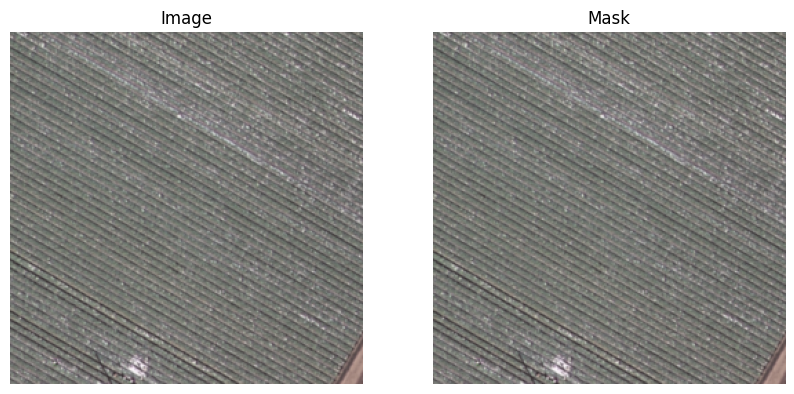

In [82]:
image, mask = train_dataset[0]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image.permute(1, 2, 0))  # Convert from tensor format (C, H, W) to (H, W, C)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask.permute(1, 2, 0))  # Convert from tensor format (C, H, W) to (H, W, C)
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()

###Model generation (U-Net) and training

#### Check GPU

In [ ]:
#check the GPU colab assigns to you
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

####Define the model (U-Net)

In [ ]:
model = smp.Unet(
    encoder_name="efficientnet-b1", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7 we chose efficientnet-b1 based on the SealNet 2.0
    encoder_weights=None,           # we do not have a pretrained model, so we put none and the model will use random weigths
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [ ]:
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding